# results フォルダに格納された結果を可視化するノートブック

以下のpythonスクリプトを実行した後に，実行結果を可視化するノートブック

- src/compute_ss_by_several_psi.py
- src/run_pension_scenarios.py

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # noqa: F401
import olg

## 結果を全て読み込む

In [4]:
# 移行過程の結果
transition_results_path = [
  "psi_50to00",
  "psi_50to25",
  "psi_50to50",
  "psi_50to75",
  "psi_50to100"
]
transition_results = {}
for path in transition_results_path:
  with open(f"results/{path}/full.pkl", "rb") as f:
    transition_results[path] = pickle.load(f)

In [7]:
transition_results.keys(), transition_results["psi_50to00"].keys()

(dict_keys(['psi_50to00', 'psi_50to25', 'psi_50to50', 'psi_50to75', 'psi_50to100']),
 dict_keys(['initial_result', 'final_result', 'converged_K_path', 'opt_indexes', 'aprimes', 'value_functions', 'mu_dist_path']))

In [8]:
# いくつかの定常状態の結果
ss_results_path = [
  "ss_psi_00",
  "ss_psi_05",
  "ss_psi_10",
  "ss_psi_15",
  "ss_psi_20",
  "ss_psi_25",
  "ss_psi_30",
  "ss_psi_35",
  "ss_psi_40",
  "ss_psi_45",
  "ss_psi_50",
  "ss_psi_75",
  "ss_psi_100"
]
ss_results = {}
for path in ss_results_path:
  with open(f"results/{path}/steady_state_result.pkl", "rb") as f:
    ss_results[path] = pickle.load(f)

In [14]:
ss_results.keys(), ss_results["ss_psi_00"].__dict__.keys()

(dict_keys(['ss_psi_00', 'ss_psi_05', 'ss_psi_10', 'ss_psi_15', 'ss_psi_20', 'ss_psi_25', 'ss_psi_30', 'ss_psi_35', 'ss_psi_40', 'ss_psi_45', 'ss_psi_50', 'ss_psi_75', 'ss_psi_100']),
 dict_keys(['K', 'r', 'w', 'p', 'tau', 'L', 'value_fun_box', 'policy_fun_box', 'optaprime_index_box', 'mu_dist_box', 'y_list', 'h_dist', 'iterations', 'market_diff', 'errm', 'computation_time', 'hp']))

## 移行過程における総資本・金利・年金の推移（図6.4）

In [15]:
result = transition_results["psi_50to25"]

In [39]:
K_path = result["converged_K_path"]

normalized_K_path = K_path / K_path[0]
r_path = (
    result["initial_result"].hp.alpha
    * (K_path / result["initial_result"].L) ** (result["initial_result"].hp.alpha - 1)
    - result["initial_result"].hp.delta
)
w_path = (1 - result["initial_result"].hp.alpha) * (
    K_path / result["initial_result"].L
) ** result["initial_result"].hp.alpha

# 今回のモデルでは，わざわざ状態分布とスキルを考慮しなくても，
# 労働人口密度と賃金をかけるだけで平均賃金がもとまる
w_bar_path = (
    w_path
    * np.sum(
        [
            result["initial_result"].hp.l_grid[i]
            * result["initial_result"].mu_dist_box[
                : result["initial_result"].hp.Njw, i, :
            ]
            for i in range(len(result["initial_result"].mu_dist_box[0, :, 0]))
        ]
    )
    / result["initial_result"].L
)

In [40]:
tr_setting = olg.transition.setting.TransitionSetting(
    NT=100,  # 移行期間
    TT=25,  # 政策変更期間
    psi_ini=0.5,  # 初期所得代替率
    psi_fin=0.25,  # 最終所得代替率
)
psi_path = tr_setting._create_replacement_rate_path()

p_path = psi_path * w_bar_path

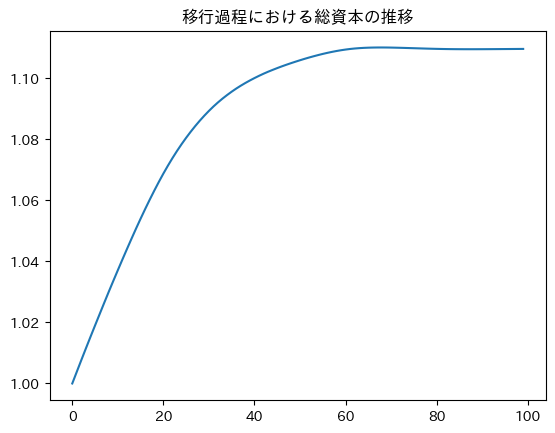

In [68]:
plt.plot(normalized_K_path)
plt.title("移行過程における総資本の推移")
plt.show()

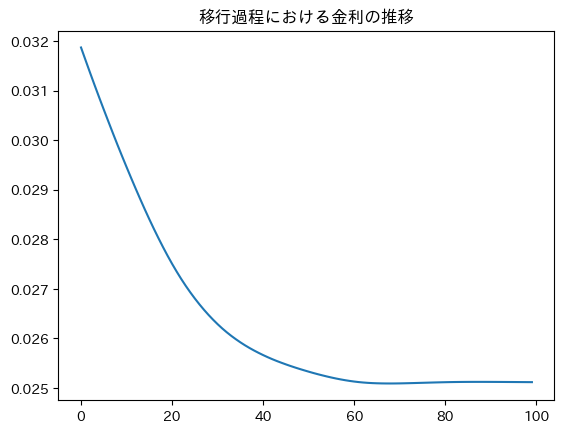

In [66]:
plt.plot(r_path)
plt.title("移行過程における金利の推移")
plt.show()

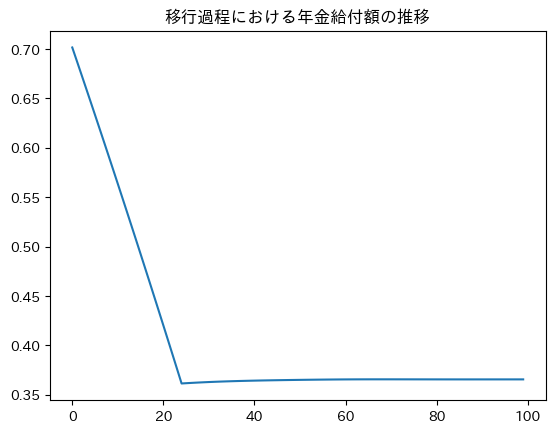

In [65]:
plt.plot(p_path)
plt.title("移行過程における年金給付額の推移")
plt.show()

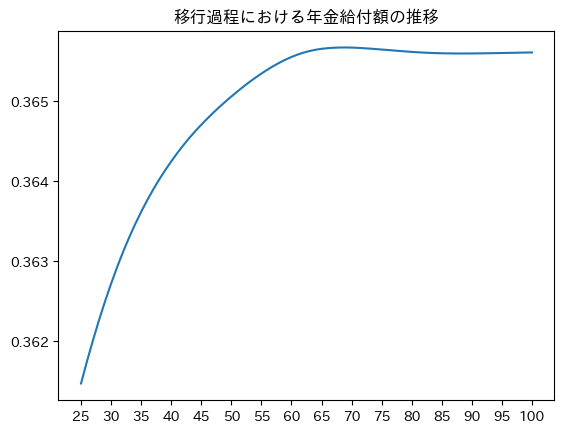

In [ ]:
plt.plot(p_path[24:])
plt.title("移行過程における年金給付額の推移（年金の所得代替率以降後）")
plt.xticks(ticks=np.arange(0, 76, 5), labels=np.arange(25, 101, 5))
plt.show()

## 政策変更による厚生効果（図6.5）